# Transfer Learning subset Walters et al.: All domain features
# Table of contents 
1. [Linear Regression](#LinearRegression)
2. [MLP (Dense)](#MLP)
3. [AE combined latent subset features](#AE_combined_subsetFeatures)
4. [AE combined latent all features](#AE_combined_allFeatures)
5. [AE OTU latent](#AE_latentOTU)

In [1]:
from data import *
from train_2 import *
from transfer_learning import *
from test_functions import *
from layers import *
from utils import *
from loss import *
from metric import *
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

Using TensorFlow backend.


In [2]:
df_microbioma_train, df_microbioma_test, \
df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, \
df_domain_train, df_domain_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test,\
otu_columns, domain_columns = read_df_with_transfer_learning_subset()

In [3]:
print(df_domain_train.shape)
print(df_domain_test.shape)
print(df_domain_transfer_learning_train.shape)
print(df_domain_transfer_learning_test.shape)

(4251, 36)
(373, 36)
(70, 36)
(30, 36)


In [5]:
print('TRAIN:')
for line in ['Maize_Line_Mixed','Maize_Line_Non_Stiff_Stalk','Maize_Line_Popcorn','Maize_Line_Stiff_Stalk','Maize_Line_Sweet_Corn','Maize_Line_Tropical']:
    count=df_domain_transfer_learning_train.loc[:,line]
    print(line + ': ' + str(sum(count)/len(count)))
print('age:' + str(df_domain_transfer_learning_train.loc[:,'age'].mean()))
print('rain:' + str(df_domain_transfer_learning_train.loc[:,'Precipitation3Days'].mean()))
print('Tª:' + str(df_domain_transfer_learning_train.loc[:,'Temperature'].mean()))
    
print('TEST:')
for line in ['Maize_Line_Mixed','Maize_Line_Non_Stiff_Stalk','Maize_Line_Popcorn','Maize_Line_Stiff_Stalk','Maize_Line_Sweet_Corn','Maize_Line_Tropical']:
    count=df_domain_transfer_learning_test.loc[:,line]
    print(line + ': ' + str(sum(count)/len(count)))
print('age:' + str(df_domain_transfer_learning_test.loc[:,'age'].mean()))
print('rain:' + str(df_domain_transfer_learning_test.loc[:,'Precipitation3Days'].mean()))
print('Tª:' + str(df_domain_transfer_learning_test.loc[:,'Temperature'].mean()))

TRAIN:
Maize_Line_Mixed: 0.05714285714285714
Maize_Line_Non_Stiff_Stalk: 0.3142857142857143
Maize_Line_Popcorn: 0.02857142857142857
Maize_Line_Stiff_Stalk: 0.1
Maize_Line_Sweet_Corn: 0.04285714285714286
Maize_Line_Tropical: 0.45714285714285713
age:9.842857142857143
rain:0.4024285714285715
Tª:70.44571428571427
TEST:
Maize_Line_Mixed: 0.13333333333333333
Maize_Line_Non_Stiff_Stalk: 0.26666666666666666
Maize_Line_Popcorn: 0.06666666666666667
Maize_Line_Stiff_Stalk: 0.13333333333333333
Maize_Line_Sweet_Corn: 0.0
Maize_Line_Tropical: 0.4
age:9.933333333333334
rain:0.3903333333333334
Tª:69.72333333333333


### Get numpy transfer_learning objects

In [6]:
data_microbioma_transfer_learning_train = df_microbioma_transfer_learning_train.to_numpy(dtype=np.float32)
data_microbioma_transfer_learning_test = df_microbioma_transfer_learning_test.to_numpy(dtype=np.float32)
data_domain_transfer_learning_train = df_domain_transfer_learning_train.to_numpy(dtype=np.float32)
data_domain_transfer_learning_test = df_domain_transfer_learning_test.to_numpy(dtype=np.float32)

# 1. Linear regression <a name="LinearRegression"></a>

In [7]:
def model(shape_in, shape_out, output_transform):
    in_layer = layers.Input(shape=(shape_in,))
    net = in_layer
    net = layers.Dense(shape_out, activation='linear')(net)
    if output_transform is not None:
        net = output_transform(net)
    out_layer = net
    
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    return model

def compile_model(model, optimizer, reconstruction_error, input_transform, output_transform):
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    model.compile(optimizer=optimizer, loss=reconstruction_error, metrics=metrics)

In [8]:
def model_fn():
    m = model(shape_in=36,
              shape_out=717,
              output_transform=None)
    
    compile_model(model=m,
                  optimizer=optimizers.Adam(lr=0.001),
                  reconstruction_error=LossMeanSquaredErrorWrapper(CenterLogRatio(), None),
                  input_transform=CenterLogRatio(),
                  output_transform=None)
    return m, None, m, None

In [9]:
latent_space = 0
results, modelsLR = train(model_fn,
                        data_microbioma_transfer_learning_train,
                        data_domain_transfer_learning_train,
                        latent_space=latent_space,
                        folds=5,
                        epochs=100,
                        batch_size=64,
                        learning_rate_scheduler=None,
                        verbose=-1)

<p>Best iteration: <b>99</b></p>

<b>loss</b>: 5.1300 (min: 5.0786, max: 5.2277)

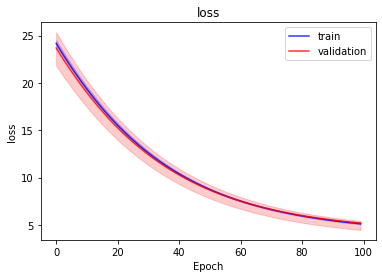

<b>domain_BrayCurtis</b>: 0.6358 (min: 0.6073, max: 0.6740)

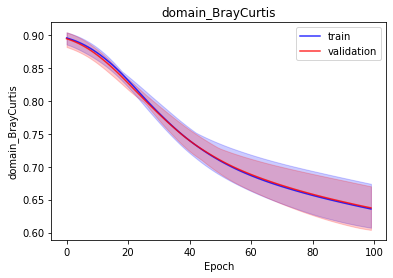

<b>domain_pearson_corr</b>: 0.2748 (min: 0.2348, max: 0.3091)

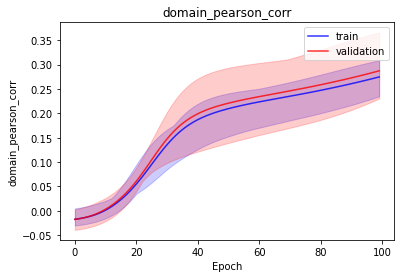

<b>domain_jensen_shannon_divergence</b>: 2.0591 (min: 1.8221, max: 2.4232)

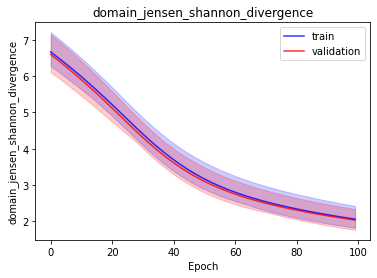

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 5.130016422271728 | 5.078619956970215 | 5.227663516998291 |
| domain_BrayCurtis | 0.6357817053794861 | 0.6072792410850525 | 0.6739987134933472 |
| domain_pearson_corr | 0.27476438879966736 | 0.23478424549102783 | 0.30910009145736694 |
| domain_jensen_shannon_divergence | 2.0591259002685547 | 1.8220767974853516 | 2.423229694366455 |


[('best_lost_epoch', 99),
 ('val_loss', [5.210087013244629, 4.483731269836426, 5.436936378479004]),
 ('val_domain_BrayCurtis', [0.63743126, 0.603943, 0.6701818]),
 ('val_domain_pearson_corr', [0.28729445, 0.23050418, 0.36648014]),
 ('val_domain_jensen_shannon_divergence', [2.033752, 1.7624465, 2.3352776])]

In [9]:
print_results(results)

In [10]:
predictions = test_model(modelsLR, CenterLogRatio, None, data_microbioma_transfer_learning_test, data_domain_transfer_learning_test)
#save_predictions(predictions, 'experiment_transfer_learning_WaltersSubset_linear_regresion.txt')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.556740939617157 | 0.5289128422737122 | 0.6269718408584595 |
| pearson_corr | 0.5474282503128052 | 0.36929842829704285 | 0.6365534663200378 |
| jensen_shannon_divergence | 1.5805952548980713 | 1.3788732290267944 | 1.7486435174942017 |


# 2. MLP (Dense) <a name="MLP"></a>

In [11]:
def model(shape_in, shape_out, output_transform, layers_list, activation_fn):
    in_layer = layers.Input(shape=(shape_in,))
    net = in_layer
    for s in layers_list:
        net = layers.Dense(s, activation=activation_fn)(net)
    net = layers.Dense(shape_out, activation='linear')(net)
    if output_transform is not None:
        net = output_transform(net)
    out_layer = net
    
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    return model

def compile_model(model, optimizer, reconstruction_error, input_transform, output_transform):
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    model.compile(optimizer=optimizer, loss=reconstruction_error, metrics=metrics)

In [17]:
def model_fn():
    m = model(shape_in=36,
              shape_out=717,
              output_transform=None,
              layers_list=[128,512],
              activation_fn='tanh')
    
    compile_model(model=m,
                  optimizer=optimizers.Adam(lr=0.001),
                  reconstruction_error=LossMeanSquaredErrorWrapper(CenterLogRatio(), None),
                  input_transform=CenterLogRatio(),
                  output_transform=None)
    return m, None, m, None

In [18]:
latent_space=0
results, modelsMLP = train(model_fn,
                        data_microbioma_transfer_learning_train,
                        data_domain_transfer_learning_train,
                        latent_space=latent_space,
                        folds=5,
                        epochs=100,
                        batch_size=64,
                        learning_rate_scheduler=None,
                        verbose=-1)

<p>Best iteration: <b>95</b></p>

<b>loss</b>: 3.7151 (min: 3.6374, max: 3.8974)

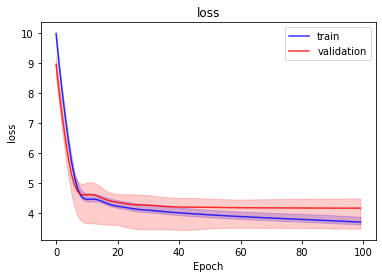

<b>domain_BrayCurtis</b>: 0.4344 (min: 0.4278, max: 0.4420)

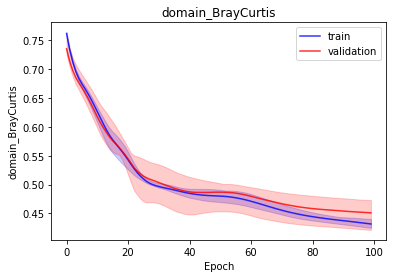

<b>domain_pearson_corr</b>: 0.7112 (min: 0.7027, max: 0.7186)

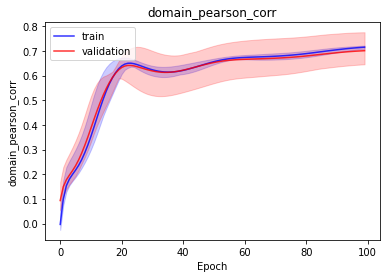

<b>domain_jensen_shannon_divergence</b>: 0.8383 (min: 0.8220, max: 0.8714)

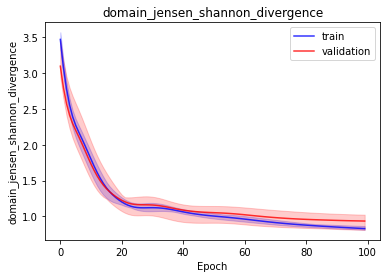

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 3.7151097297668456 | 3.6374435424804688 | 3.897383451461792 |
| domain_BrayCurtis | 0.43442025780677795 | 0.4277547299861908 | 0.44198861718177795 |
| domain_pearson_corr | 0.7112127542495728 | 0.7027086615562439 | 0.7186451554298401 |
| domain_jensen_shannon_divergence | 0.8383243680000305 | 0.8219982385635376 | 0.8714308142662048 |


[('best_lost_epoch', 95),
 ('val_loss', [4.161158657073974, 3.4784083366394043, 4.4780073165893555]),
 ('val_domain_BrayCurtis', [0.45238414, 0.4231874, 0.47428703]),
 ('val_domain_pearson_corr', [0.69784147, 0.64229923, 0.77422374]),
 ('val_domain_jensen_shannon_divergence', [0.93828696, 0.8159685, 1.0282934])]

In [19]:
print_results(results)

In [20]:
predictions = test_model(modelsMLP, CenterLogRatio, None, data_microbioma_transfer_learning_test, data_domain_transfer_learning_test)
#save_predictions(predictions, 'experiment_transfer_learning_WaltersSubset_MLP.txt')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.45099347829818726 | 0.43953755497932434 | 0.4580453932285309 |
| pearson_corr | 0.6957882046699524 | 0.6769720315933228 | 0.7077251672744751 |
| jensen_shannon_divergence | 1.072880506515503 | 1.0604100227355957 | 1.0863935947418213 |


# 3. Auto-encoder combined latent subset features <a name="AE_combined_subsetFeatures"></a>

In [40]:
from train import * 

In [41]:
df_microbioma_train, df_microbioma_test, \
df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, \
df_domain_train, df_domain_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test,\
otu_columns, domain_columns = read_df_with_transfer_learning_subset()

### Get numpy train objects

In [42]:
data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)

In [43]:
data_domain_train.shape[1]

36

### To create auto-encoder combined model

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 10 |
| Bioma Autoencoder | b -> 512 -> 256 -> 10 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 10 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>88</b></p>

<b>loss</b>: 0.6281 (min: 0.6281, max: 0.6281)

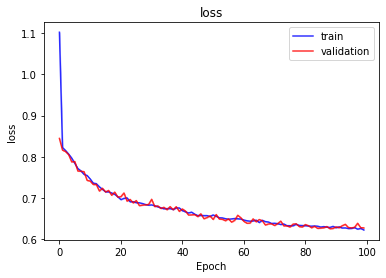

<b>bioma_loss</b>: 0.2035 (min: 0.2035, max: 0.2035)

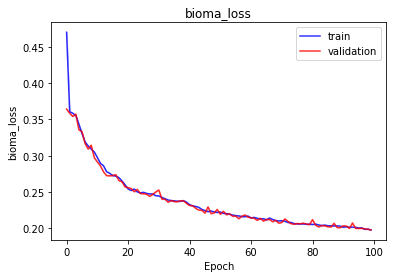

<b>domain_loss</b>: 0.4066 (min: 0.4066, max: 0.4066)

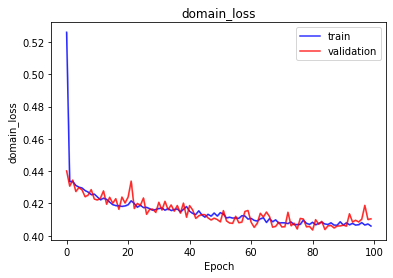

<b>latent_loss</b>: 0.0181 (min: 0.0181, max: 0.0181)

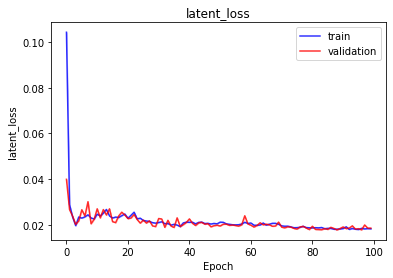

<b>bioma_mse</b>: 0.0000 (min: 0.0000, max: 0.0000)

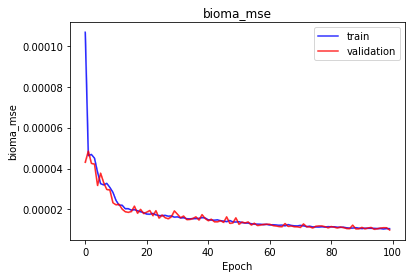

<b>bioma_mae</b>: 0.0006 (min: 0.0006, max: 0.0006)

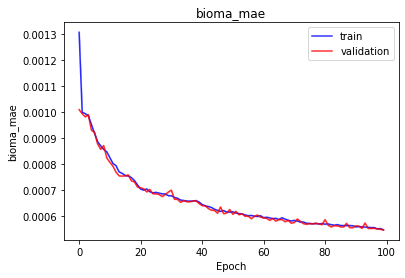

<b>bioma_mape</b>: 4990.9136 (min: 4990.9136, max: 4990.9136)

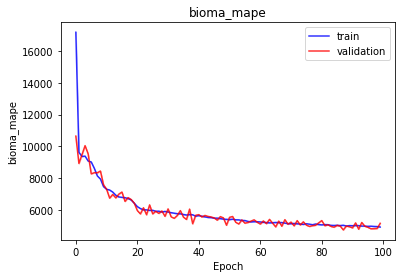

<b>bioma_BrayCurtis</b>: 0.2037 (min: 0.2037, max: 0.2037)

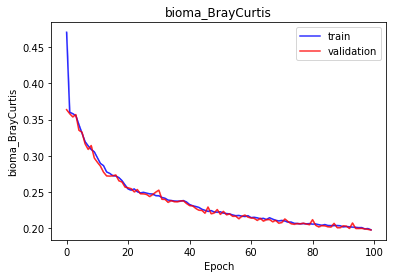

<b>bioma_pearson_corr</b>: 0.9189 (min: 0.9189, max: 0.9189)

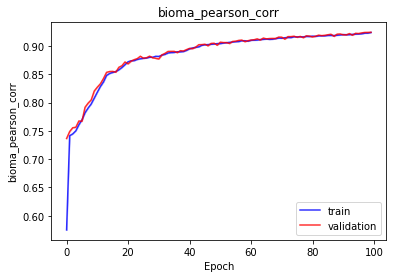

<b>bioma_jensen_shannon_divergence</b>: 0.3575 (min: 0.3575, max: 0.3575)

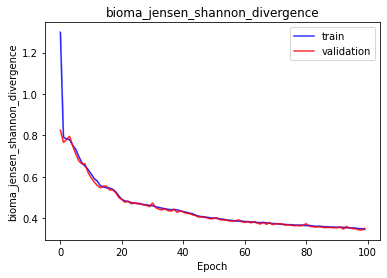

<b>domain_mse</b>: 0.0001 (min: 0.0001, max: 0.0001)

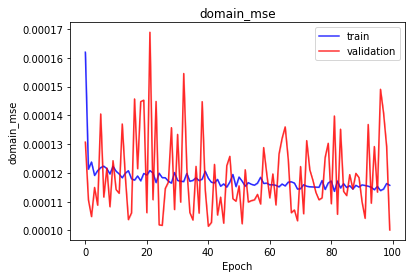

<b>domain_mae</b>: 0.0011 (min: 0.0011, max: 0.0011)

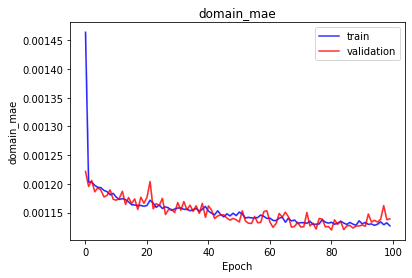

<b>domain_mape</b>: 8071.3364 (min: 8071.3364, max: 8071.3364)

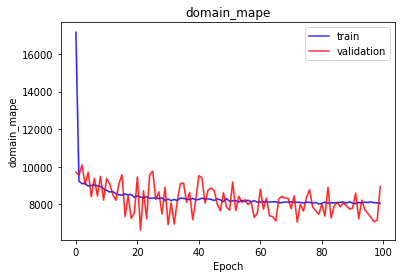

<b>domain_BrayCurtis</b>: 0.4063 (min: 0.4063, max: 0.4063)

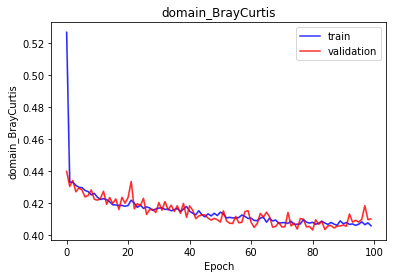

<b>domain_pearson_corr</b>: 0.7299 (min: 0.7299, max: 0.7299)

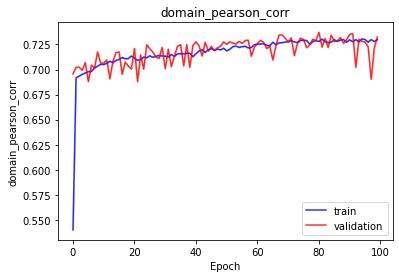

<b>domain_jensen_shannon_divergence</b>: 0.8937 (min: 0.8937, max: 0.8937)

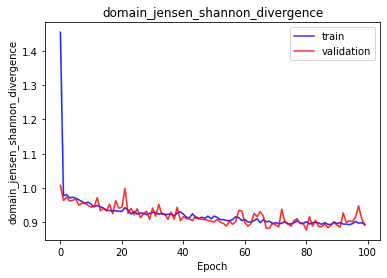

<b>latent_mae</b>: 0.0181 (min: 0.0181, max: 0.0181)

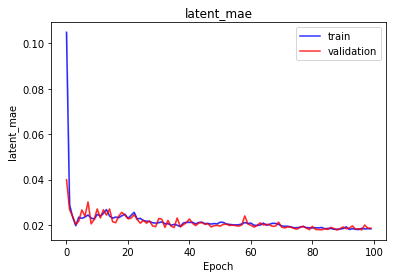

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.6281308365468277 | 0.6281308365468277 | 0.6281308365468277 |
| bioma_loss | 0.20353731513023376 | 0.20353731513023376 | 0.20353731513023376 |
| domain_loss | 0.40655675530433655 | 0.40655675530433655 | 0.40655675530433655 |
| latent_loss | 0.018124405294656754 | 0.018124405294656754 | 0.018124405294656754 |
| bioma_mse | 1.11272174763144e-05 | 1.11272174763144e-05 | 1.11272174763144e-05 |
| bioma_mae | 0.0005624765763059258 | 0.0005624765763059258 | 0.0005624765763059258 |
| bioma_mape | 4990.91357421875 | 4990.91357421875 | 4990.91357421875 |
| bioma_BrayCurtis | 0.2036895602941513 | 0.2036895602941513 | 0.2036895602941513 |
| bioma_pearson_corr | 0.918918788433075 | 0.918918788433075 | 0.918918788433075 |
| bioma_jensen_shannon_divergence | 0.3575323224067688 | 0.3575323224067688 | 0.3575323224067688 |
| domain_mse | 0.00011569513299036771 | 0.00011569513299036771 | 0.00011569513299036771 |
| domain_mae | 0.0011279369937255979 | 0.0011279369937255979 | 0.0011279369937255979 |
| domain_mape | 8071.33642578125 | 8071.33642578125 | 8071.33642578125 |
| domain_BrayCurtis | 0.40633508563041687 | 0.40633508563041687 | 0.40633508563041687 |
| domain_pearson_corr | 0.7299425005912781 | 0.7299425005912781 | 0.7299425005912781 |
| domain_jensen_shannon_divergence | 0.8937239050865173 | 0.8937239050865173 | 0.8937239050865173 |
| latent_mae | 0.018106121569871902 | 0.018106121569871902 | 0.018106121569871902 |


*************

In [44]:
# Train the selected model (the best one from those with the smallest latent space (10)): no.351
experiment_metrics, models, results = perform_experiment_2(cv_folds=0, 
                        epochs=100, 
                        batch_size=64, 
                        learning_rate=0.001, 
                        optimizer=optimizers.Adam,
                        learning_rate_scheduler=None,
                        input_transform=Percentage,
                        output_transform=tf.keras.layers.Softmax,
                        reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None), 
                        latent_space=10, 
                        layers=[512,256],
                        activation='tanh', 
                        activation_latent='tanh', 
                        data_microbioma_train=data_microbioma_train,
                        data_domain_train=data_domain_train,
                        show_results=True, 
                        device='/CPU:0')

### To get encoders and decoders to use in transfer learning model

In [45]:
model, encoder, encoder_domain, decoder = models[0]

### To predict latent space for samples in transfer learning Walters et al. subset

In [46]:
latent_transfer_learning_train = encoder.predict(data_microbioma_transfer_learning_train)
latent_transfer_learning_test = encoder.predict(data_microbioma_transfer_learning_test)

In [39]:
latent_transfer_learning_train.shape

(70, 10)

### To build model to predict latent space 
Dense model, with transfer_learning_train. With input=domain, output=10 neurons latent space

In [47]:
def model_fn_tl():
    in_layer = layers.Input(shape=(36,))
    net = layers.Dense(64, activation='tanh')(in_layer)
    net = layers.Dense(32, activation='tanh')(net)
    net = layers.Dense(16, activation='tanh')(net)
    out_layer = layers.Dense(latent_transfer_learning_train.shape[1], activation=None)(net) # 'tanh already'
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [48]:
result_tl, model_tl = train_tl_noEnsemble(model_fn_tl,
                            latent_transfer_learning_train,
                            latent_transfer_learning_train,
                            data_domain_transfer_learning_train,
                            data_domain_transfer_learning_train,
                            epochs=100,
                            batch_size=16,
                            verbose=-1)
#print_results(result_tl)
#print(result_tl)

In [49]:
# Test only Dense(domain->latent)
predictions = test_model_tl_latent(model_tl, latent_transfer_learning_test, data_domain_transfer_learning_test)
#save_predictions(predictions, 'experiment_transfer_learning_WaltersSubset_MLP_domain-latent_test.txt')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| mse | 0.0008198298746719956 | 1.6872300889758662e-08 | 0.018310362473130226 |


### a) Domain -> latent -> microbiome. Test set TL

In [50]:
predictions = test_model_tl_noEnsemble(model_tl, decoder, Percentage, tf.keras.layers.Softmax, data_microbioma_transfer_learning_test, data_domain_transfer_learning_test)

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.45959967374801636 | 0.45959967374801636 | 0.45959967374801636 |
| pearson_corr | 0.6799696683883667 | 0.6799696683883667 | 0.6799696683883667 |
| jensen_shannon_divergence | 1.1412736177444458 | 1.1412736177444458 | 1.1412736177444458 |


### b) With the encoder_domain (best case)

In [51]:
# Test with encoder_biome, en vez de model_tl
predictions = test_model_tl_noEnsemble(encoder_domain, decoder, Percentage, tf.keras.layers.Softmax, data_microbioma_transfer_learning_test, data_domain_transfer_learning_test)

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.39775383472442627 | 0.39775383472442627 | 0.39775383472442627 |
| pearson_corr | 0.7500569820404053 | 0.7500569820404053 | 0.7500569820404053 |
| jensen_shannon_divergence | 0.9096497893333435 | 0.9096497893333435 | 0.9096497893333435 |


# 4. Auto-encoder combined latent All features <a name="AE_combined_allFeatures"></a>

In [145]:
from train import *

### Get datasets with ALL domain features and numpy train objects

In [146]:
#df_microbioma_train, df_microbioma_test, \
#df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, \
#df_domain_train, df_domain_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test,\
#otu_columns, domain_columns = read_df_with_transfer_learning_subset()

In [147]:
#data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
#data_domain_train = df_domain_train.to_numpy(dtype=np.float32)

In [148]:
data_domain_train.shape[1]

36

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 10 |
| Bioma Autoencoder | b -> 512 -> 256 -> 10 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 10 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>88</b></p>

<b>loss</b>: 0.6281 (min: 0.6281, max: 0.6281)

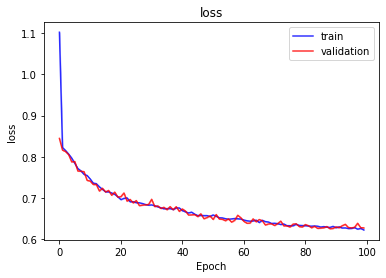

<b>bioma_loss</b>: 0.2035 (min: 0.2035, max: 0.2035)

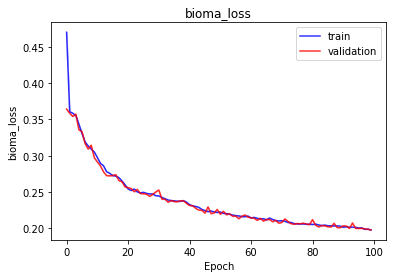

<b>domain_loss</b>: 0.4066 (min: 0.4066, max: 0.4066)

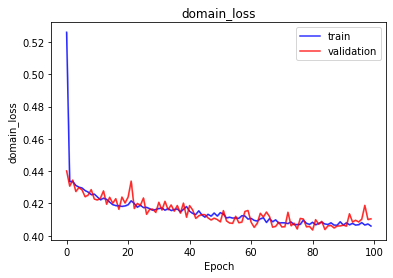

<b>latent_loss</b>: 0.0181 (min: 0.0181, max: 0.0181)

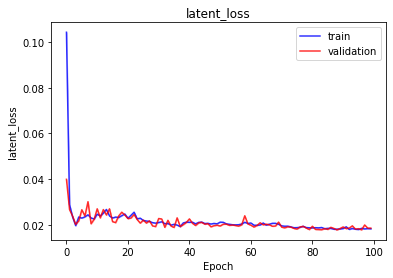

<b>bioma_mse</b>: 0.0000 (min: 0.0000, max: 0.0000)

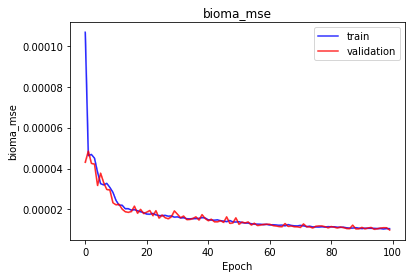

<b>bioma_mae</b>: 0.0006 (min: 0.0006, max: 0.0006)

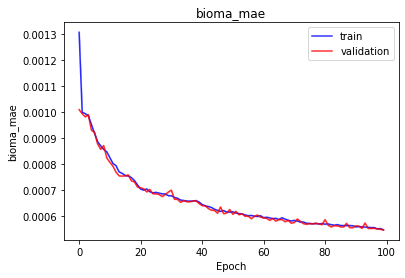

<b>bioma_mape</b>: 4990.9136 (min: 4990.9136, max: 4990.9136)

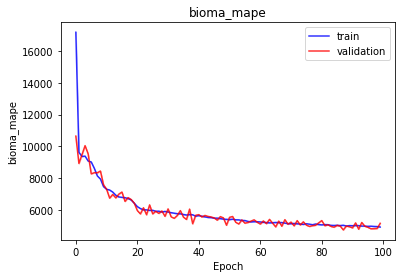

<b>bioma_BrayCurtis</b>: 0.2037 (min: 0.2037, max: 0.2037)

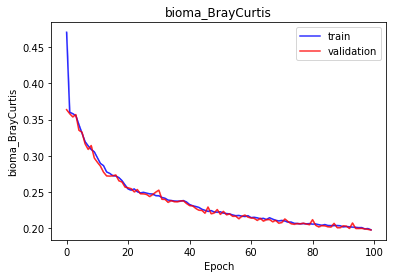

<b>bioma_pearson_corr</b>: 0.9189 (min: 0.9189, max: 0.9189)

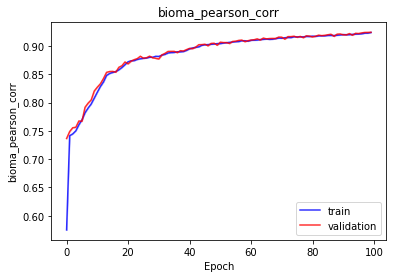

<b>bioma_jensen_shannon_divergence</b>: 0.3575 (min: 0.3575, max: 0.3575)

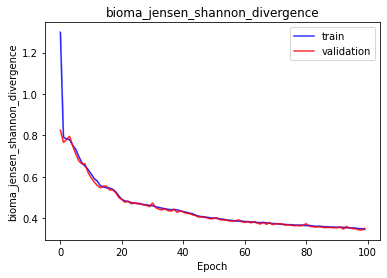

<b>domain_mse</b>: 0.0001 (min: 0.0001, max: 0.0001)

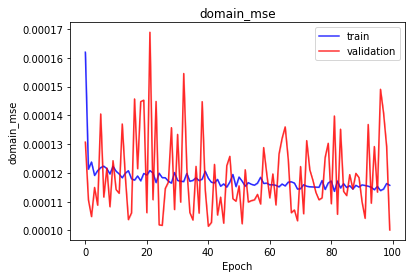

<b>domain_mae</b>: 0.0011 (min: 0.0011, max: 0.0011)

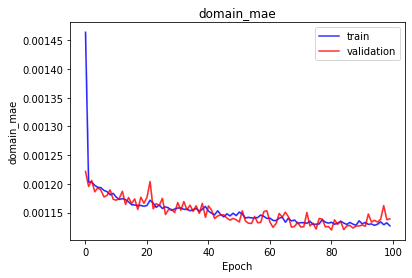

<b>domain_mape</b>: 8071.3364 (min: 8071.3364, max: 8071.3364)

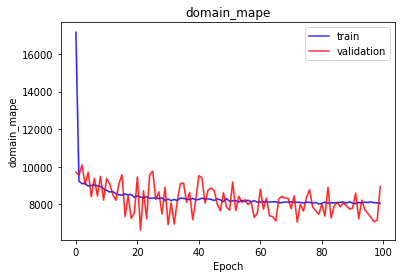

<b>domain_BrayCurtis</b>: 0.4063 (min: 0.4063, max: 0.4063)

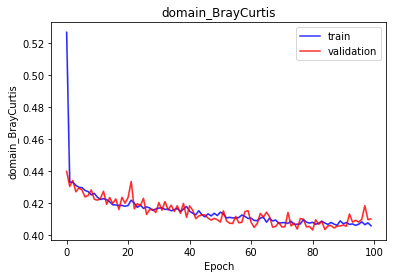

<b>domain_pearson_corr</b>: 0.7299 (min: 0.7299, max: 0.7299)

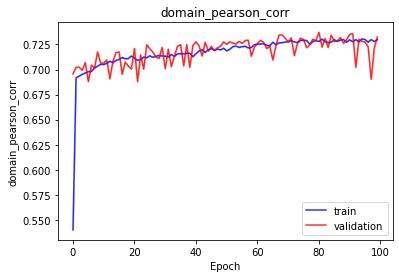

<b>domain_jensen_shannon_divergence</b>: 0.8937 (min: 0.8937, max: 0.8937)

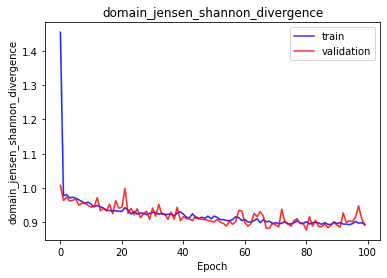

<b>latent_mae</b>: 0.0181 (min: 0.0181, max: 0.0181)

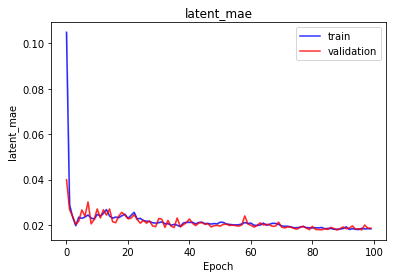

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.6281308365468277 | 0.6281308365468277 | 0.6281308365468277 |
| bioma_loss | 0.20353731513023376 | 0.20353731513023376 | 0.20353731513023376 |
| domain_loss | 0.40655675530433655 | 0.40655675530433655 | 0.40655675530433655 |
| latent_loss | 0.018124405294656754 | 0.018124405294656754 | 0.018124405294656754 |
| bioma_mse | 1.11272174763144e-05 | 1.11272174763144e-05 | 1.11272174763144e-05 |
| bioma_mae | 0.0005624765763059258 | 0.0005624765763059258 | 0.0005624765763059258 |
| bioma_mape | 4990.91357421875 | 4990.91357421875 | 4990.91357421875 |
| bioma_BrayCurtis | 0.2036895602941513 | 0.2036895602941513 | 0.2036895602941513 |
| bioma_pearson_corr | 0.918918788433075 | 0.918918788433075 | 0.918918788433075 |
| bioma_jensen_shannon_divergence | 0.3575323224067688 | 0.3575323224067688 | 0.3575323224067688 |
| domain_mse | 0.00011569513299036771 | 0.00011569513299036771 | 0.00011569513299036771 |
| domain_mae | 0.0011279369937255979 | 0.0011279369937255979 | 0.0011279369937255979 |
| domain_mape | 8071.33642578125 | 8071.33642578125 | 8071.33642578125 |
| domain_BrayCurtis | 0.40633508563041687 | 0.40633508563041687 | 0.40633508563041687 |
| domain_pearson_corr | 0.7299425005912781 | 0.7299425005912781 | 0.7299425005912781 |
| domain_jensen_shannon_divergence | 0.8937239050865173 | 0.8937239050865173 | 0.8937239050865173 |
| latent_mae | 0.018106121569871902 | 0.018106121569871902 | 0.018106121569871902 |


*************

In [149]:
# Train the selected model (the best one from those with the smallest latent space (10)): no.351
experiment_metrics, models, results = perform_experiment(cv_folds=0, 
                        epochs=100, 
                        batch_size=64, 
                        learning_rate=0.001, 
                        optimizer=optimizers.Adam,
                        learning_rate_scheduler=None,
                        input_transform=Percentage,
                        output_transform=tf.keras.layers.Softmax,
                        reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None), 
                        latent_space=10, 
                        layers=[512,256],
                        activation='tanh', 
                        activation_latent='tanh',
                        show_results=True, 
                        device='/CPU:0')

In [150]:
data_domain_train.shape

(4251, 36)

### To get encoders and decoders to use in transfer learning model

In [151]:
model, encoder, encoder_domain, decoder = models[0]

### To recover data with subset domain features

In [152]:
df_microbioma_train, df_microbioma_test, \
df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, \
df_domain_train, df_domain_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test,\
otu_columns, domain_columns = \
    read_df_with_transfer_learning_subset()

In [153]:
df_domain_train.shape

(4251, 36)

### To predict latent space for samples in transfer learning Walters et al. subset

In [154]:
latent_transfer_learning_train = encoder.predict(data_microbioma_transfer_learning_train)
latent_transfer_learning_test = encoder.predict(data_microbioma_transfer_learning_test)

### To build model to predict latent space 

In [166]:
def model_fn_tl():
    in_layer = layers.Input(shape=(36,))
    net = layers.Dense(64, activation='tanh')(in_layer)
    net = layers.Dense(32, activation='tanh')(net)
    net = layers.Dense(16, activation='tanh')(net)
    out_layer = layers.Dense(latent_transfer_learning_train.shape[1], activation=None)(net) # 'tanh already'
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [167]:
result_tl, model_tl = train_tl_noEnsemble(model_fn_tl,
                            latent_transfer_learning_train,
                            latent_transfer_learning_train,
                            data_domain_transfer_learning_train,
                            data_domain_transfer_learning_train,
                            epochs=100,
                            batch_size=16,
                            verbose=-1)
#print_results(result_tl)
#print(result_tl)

In [168]:
# Test only Dense(domain->latent)
predictions = test_model_tl_latent(model_tl, latent_transfer_learning_test, data_domain_transfer_learning_test)
#save_predictions(predictions, 'experiment_transfer_learning_WaltersSubset_MLP_domain-latent_test.txt')


## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| mse | 0.0008198298746719956 | 1.6872300889758662e-08 | 0.018310362473130226 |


### Domain -> latent -> microbiome. Test set TL

In [169]:
predictions = test_model_tl_noEnsemble(model_tl, decoder, Percentage, tf.keras.layers.Softmax, data_microbioma_transfer_learning_test, data_domain_transfer_learning_test)

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.45959967374801636 | 0.45959967374801636 | 0.45959967374801636 |
| pearson_corr | 0.6799696683883667 | 0.6799696683883667 | 0.6799696683883667 |
| jensen_shannon_divergence | 1.1412736177444458 | 1.1412736177444458 | 1.1412736177444458 |


# 5. Auto-encoder OTU latent <a name="AE_latentOTU"></a>

In [68]:
from train_2 import *

### Get microbioma train data and numpy train objects

In [69]:
df_microbioma_train, df_microbioma_test, \
df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, \
df_domain_train, df_domain_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test,\
otu_columns, domain_columns = read_df_with_transfer_learning_subset()

In [70]:
data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)

In [71]:
data_microbioma_train.shape[1]

717

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 10 |
| Bioma Autoencoder | b -> 512 -> 256 -> 10 -> 256 -> 512 -> b |
| Domain Autoencoder |   |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>99</b></p>

<b>loss</b>: 0.1631 (min: 0.1631, max: 0.1631)

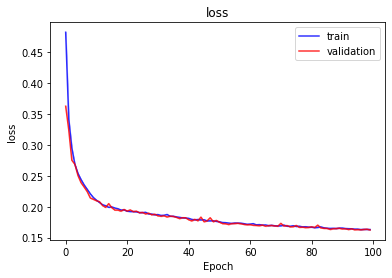

<b>bioma_mse</b>: 0.0000 (min: 0.0000, max: 0.0000)

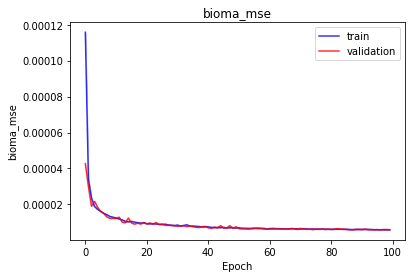

<b>bioma_mae</b>: 0.0004 (min: 0.0004, max: 0.0004)

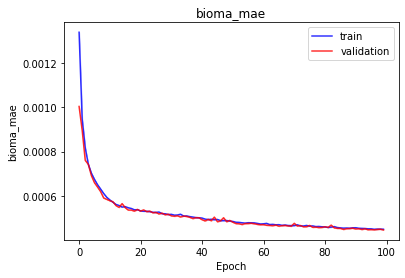

<b>bioma_mape</b>: 4060.0955 (min: 4060.0955, max: 4060.0955)

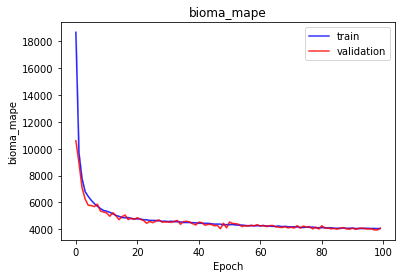

<b>bioma_BrayCurtis</b>: 0.1631 (min: 0.1631, max: 0.1631)

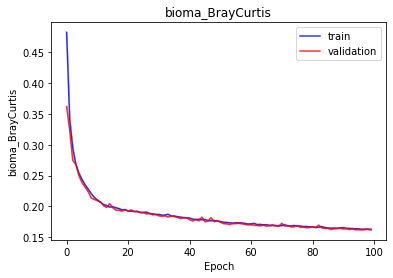

<b>bioma_pearson_corr</b>: 0.9495 (min: 0.9495, max: 0.9495)

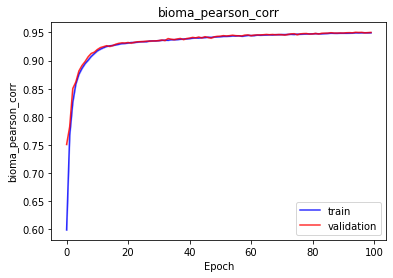

<b>bioma_jensen_shannon_divergence</b>: 0.2646 (min: 0.2646, max: 0.2646)

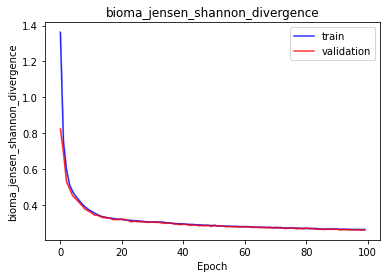

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.16313993290743248 | 0.16313993290743248 | 0.16313993290743248 |
| bioma_mse | 5.9371814131736755e-06 | 5.9371814131736755e-06 | 5.9371814131736755e-06 |
| bioma_mae | 0.00044932746095582843 | 0.00044932746095582843 | 0.00044932746095582843 |
| bioma_mape | 4060.095458984375 | 4060.095458984375 | 4060.095458984375 |
| bioma_BrayCurtis | 0.1631399542093277 | 0.1631399542093277 | 0.1631399542093277 |
| bioma_pearson_corr | 0.9494578838348389 | 0.9494578838348389 | 0.9494578838348389 |
| bioma_jensen_shannon_divergence | 0.264644593000412 | 0.264644593000412 | 0.264644593000412 |


*************

In [72]:
# Train the selected model (the best one from those with the smallest latent space (10)): no.351
experiment_metrics, models, results = perform_experiment_2(cv_folds=0, 
                        epochs=100, 
                        batch_size=64, 
                        learning_rate=0.001, 
                        optimizer=optimizers.Adam,
                        learning_rate_scheduler=None,
                        input_transform=Percentage,
                        output_transform=tf.keras.layers.Softmax,
                        reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None), 
                        latent_space=10, 
                        layers=[512,256],
                        activation='tanh', 
                        activation_latent='tanh', 
                        data_microbioma_train=data_microbioma_train,
                        data_domain_train=None,
                        show_results=True, 
                        device='/CPU:0')

### To get encoders and decoders to use in transfer learning model

In [73]:
model, encoder, _ ,decoder = models[0]

### To predict latent space for samples in transfer learning Walters et al. subset

In [75]:
latent_transfer_learning_train = encoder.predict(data_microbioma_transfer_learning_train)
latent_transfer_learning_test = encoder.predict(data_microbioma_transfer_learning_test)

### To build model to predict latent space 

In [129]:
def model_fn_tl():
    in_layer = layers.Input(shape=(36,))
    net = layers.Dense(128, activation='tanh')(in_layer)
    net = layers.Dense(64, activation='tanh')(net)
    net = layers.Dense(32, activation='tanh')(net)  
    net = layers.Dense(16, activation='tanh')(net)
    out_layer = layers.Dense(latent_transfer_learning_train.shape[1], activation=None)(net) # 'tanh already'
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [130]:
result_tl, model_tl = train_tl_noEnsemble(model_fn_tl,
                            latent_transfer_learning_train,
                            latent_transfer_learning_train,
                            data_domain_transfer_learning_train,
                            data_domain_transfer_learning_train,
                            epochs=100,
                            batch_size=16,
                            verbose=-1)
#print_results(result_tl)
print(result_tl)

In [131]:
# Test only Dense(domain->latent)
predictions = test_model_tl_latent(model_tl, latent_transfer_learning_test, data_domain_transfer_learning_test)
#save_predictions(predictions, 'experiment_transfer_learning_WaltersSubset_MLP_domain-latent_test.txt')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| mse | 0.06053992733359337 | 3.4175727705587633e-06 | 0.6893733143806458 |


### Domain -> latent -> microbiome. Test set TL

In [132]:
predictions = test_model_tl_noEnsemble(model_tl, decoder, Percentage, tf.keras.layers.Softmax, data_microbioma_transfer_learning_test, data_domain_transfer_learning_test)

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.4530680477619171 | 0.4530680477619171 | 0.4530680477619171 |
| pearson_corr | 0.7206388115882874 | 0.7206388115882874 | 0.7206388115882874 |
| jensen_shannon_divergence | 1.0486819744110107 | 1.0486819744110107 | 1.0486819744110107 |
